# Coffea-Casa Benchmark Example 4

In [1]:
import numpy as np
%matplotlib inline
import hist
import coffea.processor as processor
import awkward as ak
from coffea.nanoevents import schemas

In [2]:
# This program plots an event-level variable (MET) based on conditionals with its associated Jet arrays (in this case, where at least 2 have pT > 40)

class Processor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.axis.StrCategory(name="dataset", label="", categories=[], growth=True)
        MET_axis = hist.axis.Regular(name="MET", label="MET [GeV]", bins=50, start=0, stop=125)
        
        self.output = processor.dict_accumulator({
            'MET': hist.Hist(dataset_axis, MET_axis),
            'cutflow': processor.defaultdict_accumulator(int)
        })
    
    def process(self, events):
        dataset = events.metadata["dataset"]
        
        jets = events.Jet
        MET = events.MET.pt
        
        self.output['cutflow']['all events'] += ak.size(jets, axis=0)
        
        # We want jets with a pt of at least 40.
        pt_min = (jets.pt > 40)

        # We want MET where the above condition is met for at least two jets. The above is a list of Boolean sublists generated from the jet sublists (True if condition met, False if not). If we sum each sublist, we get the amount of jets matching the condition (since True = 1).
        good_MET = MET[(ak.sum(pt_min, axis=1) >= 2)]
        self.output['cutflow']['final events'] += ak.size(good_MET, axis=0)
        
        self.output['MET'].fill(dataset=dataset, MET=good_MET)
        return self.output

    def postprocess(self, accumulator):
        pass

In [3]:
from dask.distributed import Client

client = Client("tls://localhost:8786")

In [4]:
fileset = {'SingleMu' : ["root://eospublic.cern.ch//eos/root-eos/benchmark/Run2012B_SingleMu.root"]}

executor = processor.DaskExecutor(client=client)

run = processor.Runner(executor=executor,
                        schema=schemas.NanoAODSchema,
                        savemetrics=True
                      )

output, metrics = run(fileset, "Events", processor_instance=Processor())

metrics

{'bytesread': 1992683441,
 'columns': ['Jet_pt', 'MET_pt', 'nJet'],
 'entries': 53446198,
 'processtime': 557.0143728256226,
 'chunks': 534}

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f4db6087d00>, errorbar=None, legend_artist=None)]

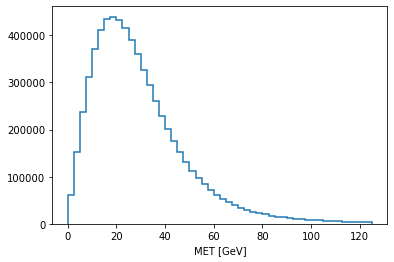

In [5]:
output['MET'].plot1d()

In [6]:
for key, value in output['cutflow'].items():
    print(key, value)

all events 53446198
final events 6665702
